In [36]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from network.cifar10_cnn_net import cifar10_cnn_net
import utils.mnist_loader as mnist_loader
import utils.mnistf_loader as mnistf_loader
import pickle
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import argparse
from numpy import ma
import scipy
import os.path
import network.ann_net as ann_net
from sklearn.linear_model import LogisticRegression
import pandas as pd

def gn_adv(args, model, device, target):
    """

    :param args:
    :param model:
    :param device:
    :param target: label for which adv image is to be generated
    :return: adv image
    """
    model.train()
    target = torch.Tensor([target]).long()
    data = torch.rand((1, 1, 28, 28), requires_grad=True, device=device)
    data, target = data.to(device), target.to(device)
    optimizer = optim.SGD([data], lr=1, momentum=args.momentum)

    for itr in range(50):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        #print(loss)
        optimizer.step()

    return torch.squeeze(data).detach().cpu().numpy()


def sneaky_adv(args, model, device, img, target, lmbd):
    """
    :param img: image whose alike image to be constructed
    :param target: label that network should output
    :return: image that looks like img and network output is target
    """
    model.train()
    data = torch.rand((1, 1, 28, 28), device=device, requires_grad=True)
    target = torch.Tensor([target]).long()
    img = torch.Tensor(img).view((1, 1, 28, 28))
    img, target, data = img.to(device), target.to(device), data.to(device)
    optimizer = optim.SGD([data], lr=0.4, momentum=args.momentum)

    for itr in range(1500):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target) + lmbd*torch.norm((img-data), 2)
        loss.backward()
        #print(loss)
        optimizer.step()

    return torch.squeeze(data).detach().cpu().numpy()
    
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))


def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def kld(model, actual):
    """
    model : its the array that is input to the network
    actual : image corresponding to the network output
    return: KL divergence between two prob distributions
    """
    model = np.asarray(list(model) + [0 for i in range(255 - len(model))])
    actual = np.asarray(list(actual) + [0 for i in range(255 - len(actual))])
    k = ((model * np.log(model)) - (model * np.log(actual))).sum()
    print(k)
    # k = (model * ma.log(model/actual)).sum()

    return k


def mean_image(tr_data):
    """

    :param tr_data: input mnist data
    :return: mean images for each class
    """'''
    val = {}
    for i in range(10):
        mat = []
        for r in range(len(tr_data)):
            if tr_data[r][1][i] == 1:
                x = tr_data[r][0]
                mat.append(np.asarray(x))
        val[i] = np.mean(mat, axis=0) * (100)

    return val'''
    #tr_data = torch.tensor(tr_data)
    val = {}
    for i in range(10):
        val[i] = []
    
    for i in range(len(tr_data)):
        val[tr_data[i][1]].append(np.asarray(tr_data[i][0]))
    
        
    for i in range(10):
        val[i] = np.asarray(val[i]).reshape((-1, 3072))
        val[i] = np.mean(val[i], axis=0)
        
    return val    


def gn_idx_list(training_data):
    idx_list = {}
    for i in range(10):
        idx_list[i] = []
    for i in range(len(training_data)):
        idx_list[training_data[i][1]].append(i)

    return idx_list    



def gn_adv_imgs(args, model, device, training_data):
    """

    :param training_data:
    :return: 100 adversarial images
    """
    gn = {}
    """idx_list = []
    for i in range(10):
        idx = np.random.randint(0, 8000)
        while training_data[idx][1][i] != 1:
            idx += 1
        idx_list.append(idx)"""
    idx_list = gn_idx_list(training_data)

    for g in range(10):
        gl = []
        print(g)
        for v in range(10):
            if g != v:
                for i in range(400):
                    idx = idx_list[v][i]
                    gl.append(sneaky_adv(args, model, device, training_data[idx][0], g, 0.4))
            else:
                for i in range(400):
                    idx = idx_list[v][i]
                    gl.append(gn_adv(args, model, device, g))
        gn[g] = gl

    return gn


def gn_pd_imgs(adv_imgs):
    """
    adv_imgs: a dictionary with keys as the classes and corresponding adv images as values
    returns gn_pd : a dictionary with keys as classes and corresponding prob. distribution of adv images
    """
    gn_pd = {}
    for k, v in adv_imgs.items():
        bin_y = []

        for i in range(len(v)):
            bin_y.append(generate_pd(v[i]))

        gn_pd[k] = bin_y

    return gn_pd


def mean_pd(mean_imgs):
    """
    val: a dictionary with keys as the classes and corresponding mean images as values
    returns val_pd : a dictionary with keys as classes and corresponding prob. distribution of mean images
    """
    val_pd = {}
    for k, v in mean_imgs.items():
        # print(k)
        # print(len(v))
        val_pd[k] = generate_pd(v)

    return val_pd


def generate_pd(img, patch_size=28):
    """
    img: an image
    returns pd : prob distribution of intensities in img
    """
    
    if img.max() - img.min() == 0:
        img = np.zeros((patch_size, patch_size))
    else:
        img = ((img - img.min()) * (1 / (img.max() - img.min()) * 255).astype('uint8'))
    img = np.floor(img)
    img = img.reshape((-1, patch_size**2))
    img = img.astype('int64')
    bin_m = np.bincount(img[0])
    l1 = list(bin_m)
    l2 = [0]*(256 - len(bin_m))
    bin_m = l1 + l2
    bin_m = [x if x != 0 else 0.0001 for x in bin_m] 
    bin_m = bin_m / sum(bin_m)
    # making sure to have len of list 255
    pd = np.asarray(bin_m)
    #pd = [x if x != 0 else 0.0001 for x in pd]  # to avoid divide by zero in KLD

    return pd



def kl_calc(adv_im, mean_im):
    """
    """
    adv_im = np.asarray(adv_im).reshape(28, 28)
    mean_im = np.asarray(mean_im).reshape(28, 28)
    k_sum = 0
    for i in range(4):
        for j in range(4):
            s_arr = adv_im[i: i + 7, i: i + 7]
            p = generate_pd(s_arr, 7)
            # mean image pd
            ms_arr = mean_im[i: i + 7, i: i + 7]
            q = generate_pd(ms_arr, 7)
            k_sum += scipy.stats.entropy(p, q)

    return k_sum

def js_calc(adv_im, mean_im):
    """
    """
    adv_im = np.asarray(adv_im).reshape(28, 28)
    mean_im = np.asarray(mean_im).reshape(28, 28)
    k_sum = 0
    for i in range(4):
        for j in range(4):
            s_arr = adv_im[i: i + 7, j: j + 7]
            p = generate_pd(s_arr, 7)
            # mean image pd
            ms_arr = mean_im[i: i + 7, j: j + 7]
            q = generate_pd(ms_arr, 7)
            r = (p + q)/ 2
            k_sum += (scipy.stats.entropy(p, r) / 2) + (scipy.stats.entropy(q, r) / 2)

    return k_sum

def ac_calc(test_data, training_data, adv_imgs, mean_imgs, min_thr, fun):
    """
    
    """
    min_thr = min_thr_calc(adv_imgs, mean_imgs, fun)
    
    success = 0
    tmp = 1000
    for i in range(len(adv_imgs)):
        f = adv_imgs[i]
        for j in range(len(f)):
            tmp = fun(f[j],mean_imgs[i])
            if tmp >= min_thr[i]:
                success += 1

    #print((success/40000) * 100)
    #success = 0
    tmp = 1000
    for i in range(400):
        label = np.argmax(test_data[i][1])
        f = np.asarray(test_data[i][0]).reshape((-1, 784))
        tmp = fun(f, mean_imgs[label])
        if tmp < min_thr[label]:
            success += 1
    '''
    for i in range(len(training_data)):
        label = np.argmax(training_data[i][1])
        f = np.asarray(training_data[i][0]).reshape((-1, 784))
        tmp = fun(f, mean_imgs[label])
        if tmp < min_thr[label]:
            success += 1
'''
    return (success/(len(adv_imgs)*len(adv_imgs[0]) + 400)* 100)


def min_thr_calc(adv_imgs, mean_imgs, fun):
    """
    # each class contain 4000 adversarial examples
    # 400 uniformly chosen samples out of 4000 are used for min_thr calc
    return: list containing min_thr for each of the 10 classes
    """
    min_thr = []
    ind = np.random.randint(40, size=4)
    tmp = 1000
    for i in range(len(adv_imgs)):
        f = adv_imgs[i]
        for j in ind:
            tmp = min(tmp, fun(f[j], mean_imgs[i]))
        if (tmp == 1000):
            print(i)
        min_thr.append(tmp) 
        tmp =1000
    
    return min_thr


In [37]:
#def main():
    # Training settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=30, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.1, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=True,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')

parser.add_argument('--save-model', action='store_true', default=False,
                    help='For Saving the current Model')
args = parser.parse_args([])
use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data/cifar10', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data/cifar10', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

model = cifar10_cnn_net().to(device)
optimizer = None

training_data =  datasets.CIFAR10('data/cifar10', train=True)

mean_imgs = mean_image(training_data)
# for training of the cnn-network
'''if (args.save_model):
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(args, model, device, test_loader)

    torch.save(model.state_dict(), "cifar10_cnn.pt")

# to generate adversarial images from trained network
model.load_state_dict(torch.load("cifar10_cnn.pt"))
model.eval()


for target in range(10):
    res = gn_adv(args, model, device, target)
    print(res.shape)
    res = torch.Tensor(res).reshape(1, 1, 28, 28)
    output = model(res)
    pred = output.argmax(dim=1, keepdim=True)
    print(pred)
    
''''''# generate sneaky_adversarial images test code
target_label = 1
target_img = 4
idx = np.random.randint(0, 8000)
while training_data[idx][1][target_img] != 1:
    idx += 1
#training_data[idx][0]
res = sneaky_adv(args, model, device, training_data[idx][0], target_label, 0.3)
plt.imshow(res.reshape(28, 28), cmap="Greys")
res = torch.Tensor(res).reshape(1, 1, 28, 28)
output = model(res)
pred = output.argmax(dim=1, keepdim=True)
print(pred)

# generate adversarial images
if os.path.exists('adv_imgs_mnistf.pkl'):
    print("file_exist")
    with open('adv_imgs_imgs_mnistf.pkl', 'rb') as f:
        adv_imgs = pickle.load(f)
else:
    adv_imgs = gn_adv_imgs(args, model, device, training_data)
    with open("adv_imgs_mnistf.pkl", "wb") as fp:   #Pickling
        pickle.dump(adv_imgs, fp)
print(len(adv_imgs[0]))
#x = adv_imgs[1]
#y = x[800]
#plt.imshow(y.reshape(28, 28), cmap='Greys')
#prb = generate_pd(training_data[1][0]*100)'''


'''success = 0
for i in range(10):
    for j in range(len(adv_imgs[i])):
        res = adv_imgs[i][j]
        res = torch.Tensor(res).reshape(1, 1, 28, 28)
        output = model(res)
        pred = output.argmax(dim=1, keepdim=True)

        if pred == i:
            success += 1

print((success/ 40000) * 100)
#print(pred)
res = res.detach().numpy()
#plt.imshow(res.reshape(28, 28), cmap="Greys")
#plt.show()
'''



'''mean_imgs = mean_image(training_data)
#y = mean_imgs[2]
#plt.imshow(y.reshape(28, 28), cmap='Greys')
idx_l = gn_idx_list(training_data)
'''

'''fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(tr_l, np.zeros((len(tr_l))), s=10, c='b', marker="s", label='train')
ax1.scatter(ad_l, np.ones((len(ad_l))), s=10, c='r', marker="o", label='adversarial')
plt.legend(loc='upper left');
plt.show()
'''    

#Calculating threshold
#min_thr = min_thr_calc(adv_imgs, mean_imgs, kl_calc) 
#print(ac_calc(test_data, training_data, adv_imgs, mean_imgs, min_thr, kl_calc))
#print(ac_calc(test_data, training_data, adv_imgs, mean_imgs, js_calc))

#min_thr = min_thr_calc(adv_imgs, mean_imgs, js_calc) 
#print(ac_calc(test_data, training_data, adv_imgs, mean_imgs, min_thr, js_calc))


Files already downloaded and verified


'fig = plt.figure()\nax1 = fig.add_subplot(111)\n\nax1.scatter(tr_l, np.zeros((len(tr_l))), s=10, c=\'b\', marker="s", label=\'train\')\nax1.scatter(ad_l, np.ones((len(ad_l))), s=10, c=\'r\', marker="o", label=\'adversarial\')\nplt.legend(loc=\'upper left\');\nplt.show()\n'

[[[136 138 135]
  [136 137 135]
  [137 138 136]
  ..., 
  [137 138 136]
  [136 138 135]
  [135 137 135]]

 [[135 136 134]
  [135 136 133]
  [136 137 134]
  ..., 
  [135 137 134]
  [134 136 133]
  [133 135 133]]

 [[133 134 131]
  [133 134 131]
  [134 134 131]
  ..., 
  [133 135 131]
  [133 134 131]
  [132 133 130]]

 ..., 
 [[132 130 125]
  [128 126 121]
  [124 122 116]
  ..., 
  [126 124 119]
  [130 127 122]
  [132 130 125]]

 [[133 131 126]
  [130 128 123]
  [128 126 120]
  ..., 
  [130 127 122]
  [131 129 124]
  [133 131 126]]

 [[134 132 127]
  [132 130 125]
  [131 129 124]
  ..., 
  [132 129 124]
  [132 130 125]
  [133 131 126]]]


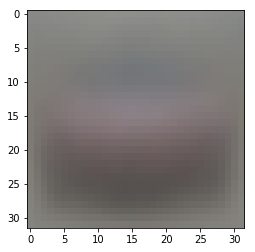

In [41]:
from PIL import Image
im = np.asarray(mean_imgs[1].reshape(32, 32, 3), dtype="uint8")
print(im)
img = Image.fromarray(im)
plt.imshow(img)

In [12]:
m = mean_imgs[5].reshape((-1, 32*32*3))
m.shape

(1, 3072)

In [23]:
def pca(im_data):
    """
    """
    im = np.asarray(im_data[:100])
    im = im.reshape((-1, 3072))
    
    face_db = im.T
    
    M = np.mean(face_db, axis=1) #mean calculation
    M = M.reshape(3072, 1)
    delta = face_db - M  #mean zero images
    
    #covariance of dimension pxp
    c = np.cov(delta.T) 
    
    eigen_values, eigen_vectors = LA.eig(c)
    feature_vector = eigen_vectors
    
    eigen_face = np.dot(delta, feature_vector)
    
    #eigen_projection = np.dot(eigen_face.T, delta)
    print(eigen_face.shape)
    
    #mean eigen face for each class
    #mean_eig = np.mean(eigen_face, axis=0)
    #mean_eig = mean_eig.real
    
    #plt.imshow(mean_eig.reshape(28, 28), cmap='Greys')
    #return mean_eig
    return eigen_face

    

In [24]:
def eigen_image(tr_data):
    """
    """
    
    '''eig_im = {}
    for i in range(10):
        mat = []
        for r in range(len(tr_data)):
            if tr_data[r][1][i] == 1:
                x = tr_data[r][0]
                mat.append(np.asarray(x))
        eig_im[i] = pca(mat)
        
    return eig_im'''

    val = {}
    eig_im = {}
    for i in range(10):
        val[i] = []
    
    for i in range(len(tr_data)):
        val[tr_data[i][1]].append(np.asarray(tr_data[i][0]))
        
    for i in range(10):
        eig_im[i] = pca(val[i])
        
    return eig_im    


eig_images = eigen_image(training_data)
#plt.imshow(eig_images[3].reshape(28, 28), cmap='Greys')

(3072, 100)
(3072, 100)
(3072, 100)
(3072, 100)
(3072, 100)
(3072, 100)
(3072, 100)
(3072, 100)
(3072, 100)
(3072, 100)


In [32]:
m = np.mean(eig_images[0], axis=1)

[[[  3   4   6]
  [  6   5   7]
  [  6   6   7]
  ..., 
  [  7   5   5]
  [  7   5   6]
  [  6   4   5]]

 [[  4   5   6]
  [  7   6   7]
  [  7   6   7]
  ..., 
  [  7   5   5]
  [  7   5   6]
  [  6   5   5]]

 [[  4   4   6]
  [  7   6   7]
  [  7   6   6]
  ..., 
  [  9   6   6]
  [  8   6   6]
  [  7   5   5]]

 ..., 
 [[253 252 253]
  [254 254 254]
  [253 253 253]
  ..., 
  [255 254 253]
  [  0 255 255]
  [254 254 254]]

 [[255 254 255]
  [  0 255 255]
  [254 254 255]
  ..., 
  [  0 255 255]
  [  0 255 255]
  [255 254 254]]

 [[255 253 253]
  [254 252 252]
  [253 253 253]
  ..., 
  [254 253 253]
  [255 254 253]
  [  0 255 255]]]


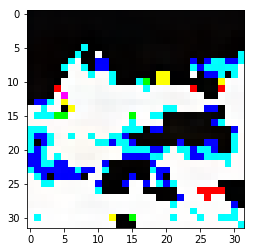

In [33]:
from PIL import Image
mi = np.asarray(m.reshape(32, 32, 3), dtype="uint8")
print(mi)
mg = Image.fromarray(mi)
plt.imshow(mg)

In [ ]:
tr_l = []
ad_l = []
for j in range(10):
    lst = idx_l[j]
    for i in range(4000):
        ind = lst[i]
        tr_l.append(js_calc(training_data[ind][0], mean_imgs[j]))
    for i in range(4000):
        ad_l.append(js_calc(adv_imgs[j][i], mean_imgs[j]))
        
y = [0]*len(ad_l) + [1]*len(tr_l)
x = ad_l + tr_l
x2 = [i**2 for i in x]
x3 = [i**3 for i in x]
data = {'x': x, 'x2': x2, 'x3': x3, 'y': y}
df = pd.DataFrame(data)
df = df.sample(frac=1).reset_index(drop=True)                   
n_df = df[['x', 'x2', 'x3']]
normalized_df = (n_df - n_df.mean()) / n_df.std()
normalized_df['y'] = df['y']

print(df.head(1000))


logreg = LogisticRegression()

# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(normalized_df[['x', 'x2', 'x3']][:60000], normalized_df['y'][:60000])

res = logreg.predict(normalized_df[['x', 'x2', 'x3']][60000:])
Y = np.asarray(normalized_df['y'][60000:])
acc = (np.sum(Y == res) / 20000)*100
                   
                   
